# Convolutional Neural Networks (CNNs)

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Ehsan Hassanbeygi

*SID:* 402211723

In this homework, you will work with [Google colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on Google servers using a GPU/TPU. To enable GPU support, make sure to press `Runtime -> Change Runtime Type -> GPU`. 

## Task: Cats vs Dogs

To learn about CNNs we will be working on a problem of great importance in computer vision, **classifying images of cats and dogs** :)

The problem is so important that there's even an easter egg in colab: go to `Tools -> Settings -> Miscellaneous and enable 'Kitty mode' and 'Corgi mode'` to get more cats and dogs to classify when you're tired of coding :)

### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):

In [1]:
! wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2024-04-01 20:39:33--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 142.250.99.207, 74.125.20.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: './cats_and_dogs_filtered.zip'

./cats_and_dogs_fil 100%[===================>]  65.43M   152MB/s    in 0.4s    

2024-04-01 20:39:33 (152 MB/s) - './cats_and_dogs_filtered.zip' saved [68606236/68606236]



In [2]:
! unzip -q cats_and_dogs_filtered.zip 

### Dataset Organization
Our dataset contains two directories, `train` and `validation`, both containing two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats and 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a CNN to classify these images, i.e. given an image from this dataset, tell if it contains a *cat* or a *dog*.

```bash
├── dir.txt
├── train
│   ├── cats
│   │   ├── cat.0.jpg
│   │   ├── cat....jpg
│   │   ├── cat.999.jpg
│   └── dogs
│       ├── dog.0.jpg
│       ├── dog....jpg
│       ├── dog.999.jpg
├── validation
│   ├── cats
│   │   ├── cat.2000.jpg
│   │   ├── cat....jpg
│   │   └── cat.2499.jpg
│   └── dogs
│       ├── dog.2000.jpg
│       ├── dog....jpg
│       └── dog.2499.jpg
└── vectorize.py

6 directories, 3002 files
```

### Loading the data
 Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html). 

 Torchvision is a Pytorch library with many commonly used tools in computer vision. In the case of computer vision, the datasets with the folder structure `label_name/image_file` are very common, and to process those there's already an implemented class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)). 

 Another thing we need from Torchvision library is [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html). In computer vision, we very often want to transform the images in certain ways. The most common is **normalization**. Others include *flipping*, changing *saturation*, *hue*, *contrast*, *rotation*, and *blurring*. 

 Below, we create training, validation and test sets. We use a few transforms for **augmentation** on the training set, but we don't use anything but **resize** and **normalization** for validation and test. 

In [3]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image

# These numbers are mean and std values for channels of natural images.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Inverse transformation which is needed for plotting.
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
)

train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(hue=0.1, saturation=0.1, contrast=0.1),
        transforms.RandomRotation(20, interpolation=Image.Resampling.BILINEAR),
        transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
        transforms.ToTensor(),  # This is necessary to convert PIL to torch Tensor
        normalize,
    ]
)

validation_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        normalize,
    ]
)

train_dataset = torchvision.datasets.ImageFolder(
    "./cats_and_dogs_filtered/train", transform=train_transforms
)
test_dataset = torchvision.datasets.ImageFolder(
    "./cats_and_dogs_filtered/validation", transform=validation_transforms
)

validation_dataset, test_dataset = torch.utils.data.random_split(
    test_dataset, [500, 500], generator=torch.Generator().manual_seed(42)
)

### Dataset Inspection
Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):

torch.Size([3, 256, 256])


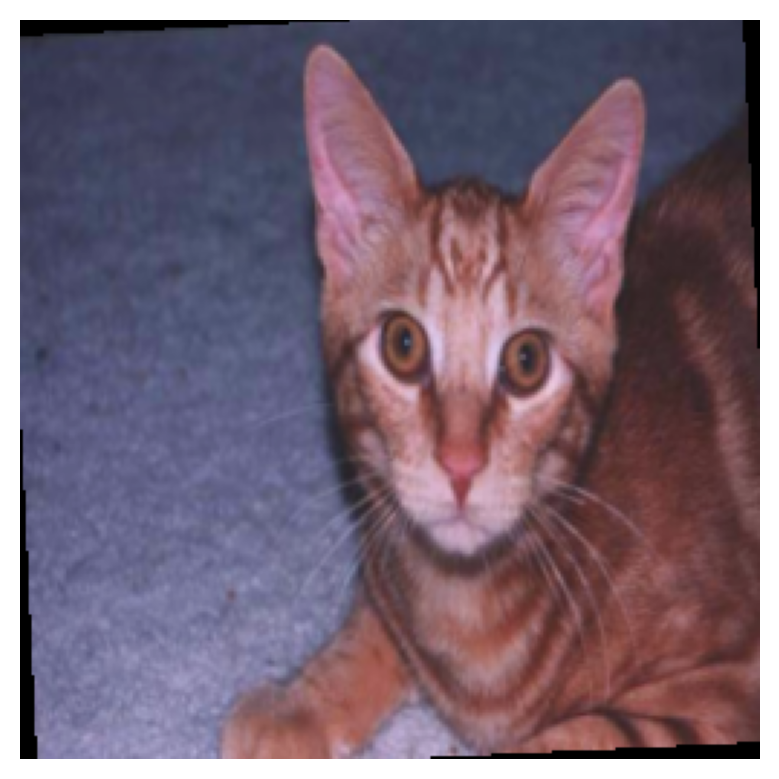

In [4]:
from matplotlib import pyplot as plt

plt.rcParams["figure.dpi"] = 200  # change dpi to make plots bigger


def show_normalized_image(img, title=None):
    plt.imshow(inv_normalize(img).detach().cpu().permute(1, 2, 0))
    plt.title(title)
    plt.axis("off")


print(train_dataset[10][0].shape)
show_normalized_image(train_dataset[10][0])

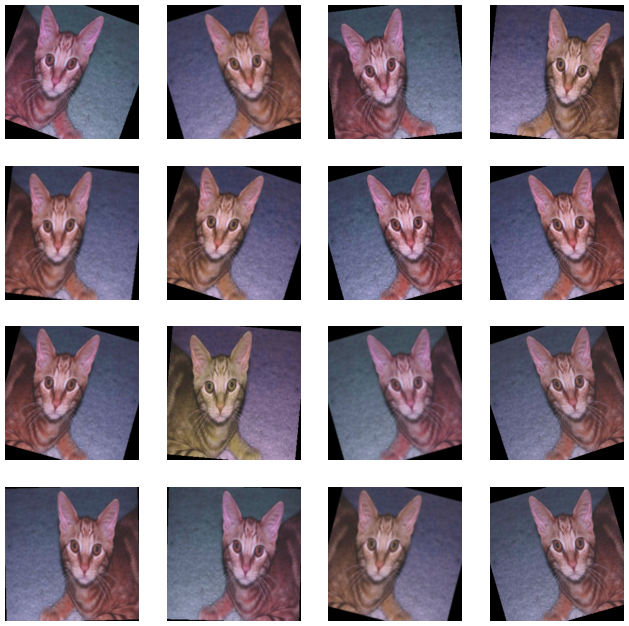

In [5]:
# checking the augmentation
plt.rcParams["figure.dpi"] = 50
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    show_normalized_image(train_dataset[10][0])
plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Creating the model

Now is the time to create a model. 

All models in Pytorch are subclassing `torch.nn.Module`. We have to implement `__init__` and `forward` methods. 

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a CNN containing the following elements:

* Convolutional layers (at least two)
* Pooling layers
* Non-linearity
* Residual connections similar to that of **ResNet**
* fully connected layer(s)

Note that you cannot use Batch Normalization layers in this step.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNN_cat_dog(torch.nn.Module):

    def __init__(self, in_channels, num_classes):
        super().__init__()
        # TODO
        self.conv1 = nn.Conv2d(
            in_channels,
            64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.res_block1_1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.res_block1_2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        ##################################################################
        self.conv2 = nn.Conv2d(
            64,
            128,
            kernel_size=1,
            stride=2,
            bias=False,
        )
        self.res_block2_1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.res_block2_2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        ##################################################################
        self.conv3 = nn.Conv2d(
            128,
            256,
            kernel_size=1,
            stride=2,
            bias=False,
        )
        self.res_block3_1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.res_block3_2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        ##################################################################
        self.conv4 = nn.Conv2d(
            256,
            512,
            kernel_size=1,
            stride=2,
            bias=False,
        )
        self.res_block4_1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.res_block4_2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        ##################################################################
        self.pool2 = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # TODO
        x = self.pool1(F.relu(self.conv1(x)))
        x = x + self.res_block1_1(x)
        x = x + self.res_block1_2(x)

        x = F.relu(self.conv2(x))
        x = x + self.res_block2_1(x)
        x = x + self.res_block2_2(x)

        x = F.relu(self.conv3(x))
        x = x + self.res_block3_1(x)
        x = x + self.res_block3_2(x)

        x = F.relu(self.conv4(x))
        x = x + self.res_block4_1(x)
        x = x + self.res_block4_2(x)

        x = self.fc(self.flatten(self.pool2(x)))

        return x

In [8]:
model = CNN_cat_dog(in_channels=3, num_classes=2)
model.to(device)

CNN_cat_dog(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (res_block1_1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (res_block1_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (res_block2_1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (res_block2_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 

### Training the model

Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.

In [9]:
from tqdm.notebook import tqdm
import torch.optim as optim


def get_loss_and_correct(model, batch, criterion, device):
    # Implement forward pass and loss calculation for one batch.
    # Remember to move the batch to device.
    #
    # Return a tuple:
    # - loss for the batch (Tensor)
    # - number of correctly classified examples in the batch (Tensor)
    # TODO
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    y_hat = model(inputs)
    loss = criterion(y_hat, labels)
    y_pred = torch.argmax(y_hat, axis=1)

    return loss, torch.sum(torch.eq(y_pred, labels))


def step(loss, optimizer):
    # Implement backward pass and update.
    # TODO
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

In [10]:
N_EPOCHS = 40  # TODO
BATCH_SIZE = 64  # TODO
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
)
validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, num_workers=4
)
model = CNN_cat_dog(in_channels=3, num_classes=2)
model.to(device)

criterion = nn.CrossEntropyLoss()  # TODO
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-4)  # TODO

model.train()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
    total_train_loss = 0.0
    total_train_correct = 0.0
    total_validation_loss = 0.0
    total_validation_correct = 0.0

    model.train()

    for batch in tqdm(train_dataloader, leave=False):
        # use `get_loss_and_correct` to perform a step and save train loss and corrects
        # TODO
        loss, num_correct = get_loss_and_correct(model, batch, criterion, device)
        total_train_loss += loss.item()
        total_train_correct += num_correct.item()
        step(loss, optimizer)

    with torch.no_grad():
        for batch in validation_dataloader:
            # use `get_loss_and_correct` to perform a step and save validation loss and corrects
            # TODO
            loss, num_correct = get_loss_and_correct(model, batch, criterion, device)
            total_validation_loss += loss.item()
            total_validation_correct += num_correct.item()

    mean_train_loss = total_train_loss / len(train_dataloader)  # TODO
    train_accuracy = total_train_correct / len(train_dataloader.dataset)  # TODO

    mean_validation_loss = total_validation_loss / len(validation_dataloader)  # TODO
    validation_accuracy = total_validation_correct / len(
        validation_dataloader.dataset
    )  # TODO

    train_losses.append(mean_train_loss)
    validation_losses.append(mean_validation_loss)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    pbar.set_postfix(
        {
            "train_loss": mean_train_loss,
            "validation_loss": mean_validation_loss,
            "train_accuracy": train_accuracy,
            "validation_accuracy": validation_accuracy,
        }
    )

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Now that the model is trained, we want to visualize the training and validation losses and accuracies:

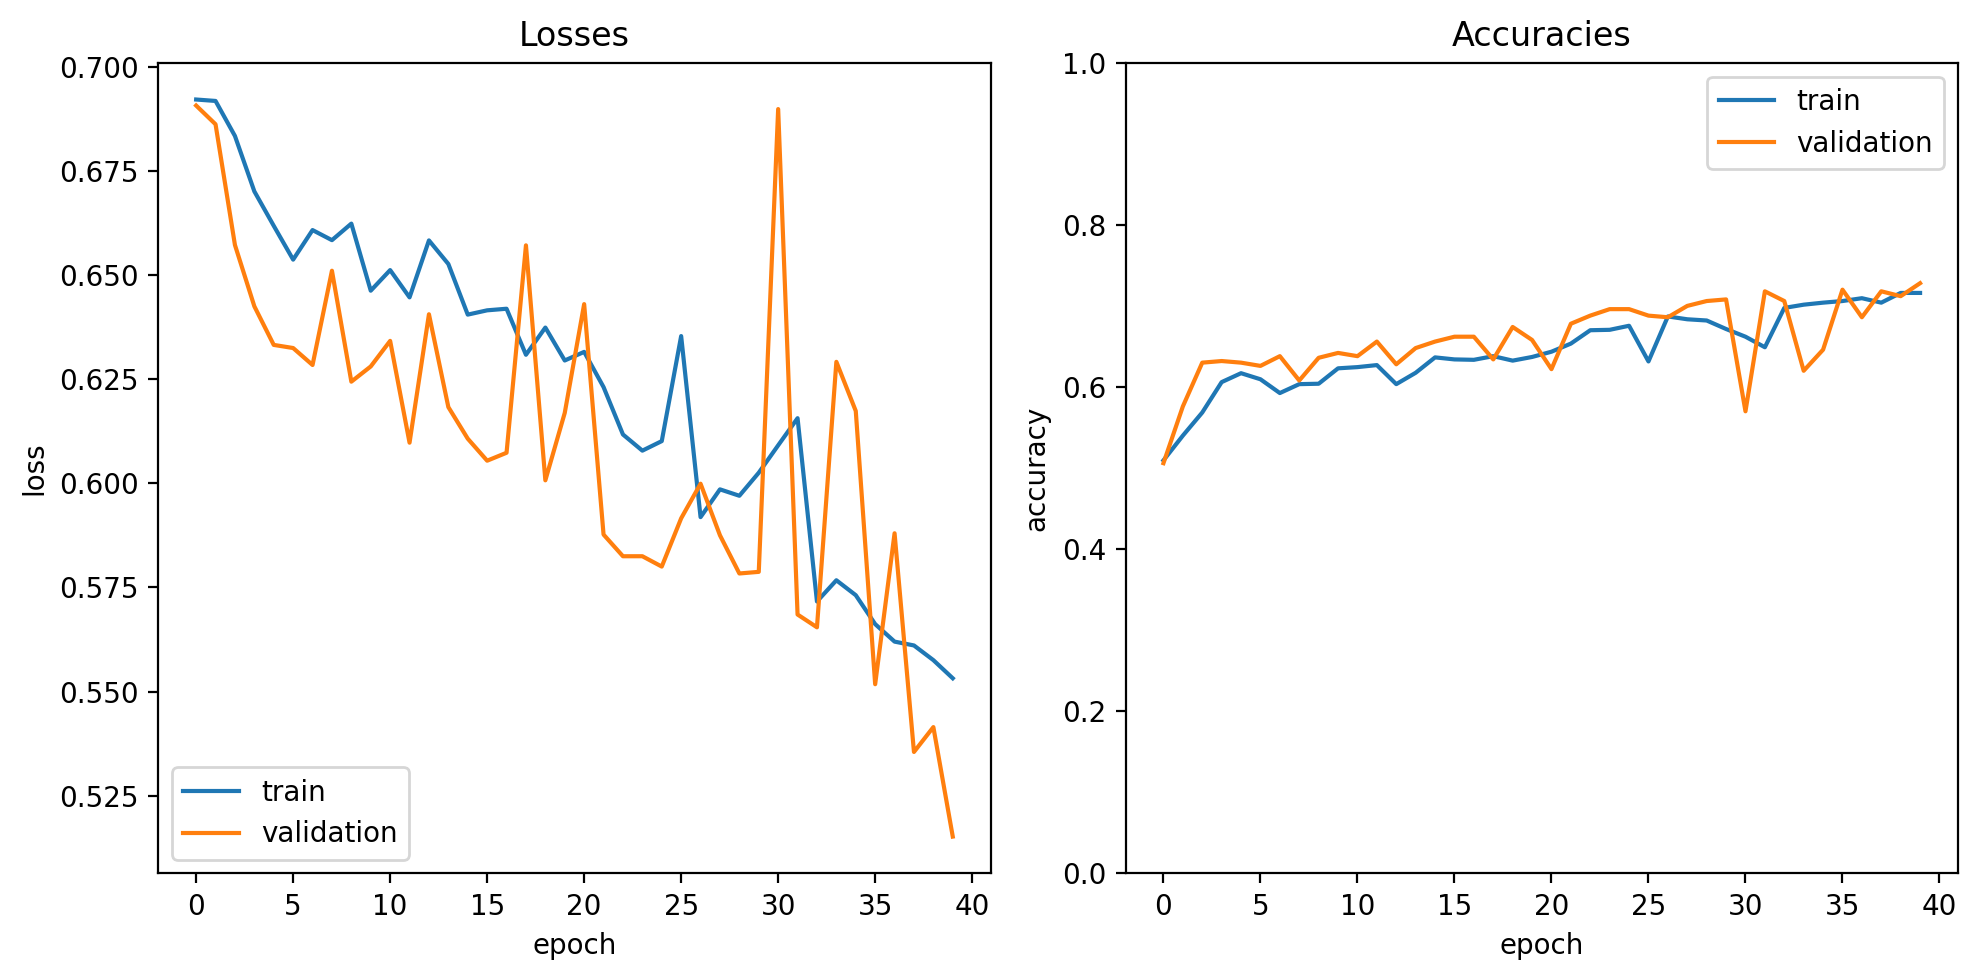

In [11]:
plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()
plt.show()

Now, change your model to achieve at least 75% accuracy on validation set. Add Dropout and Batch Norm layers where needed. You can change the model you've implemented (including the model depth, activation functions, etc.), the optimizer (including the regularizer terms), and the augmentations. 

#### Question
Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?


Looking at the above plots we can see that our first model doesn't overfit the training set.
This is due to training for lower epochs and obviously if we train the model long enough, it will eventually overfit. In fact we can see this behaviour in loss and accuracy plots of the second (improved) model.

The reason is that our first model is not as good as the second model so it's slower and needs more epochs to train, thus we don't see overfitting even at 40th epoch (because it's still learning).
But the second model is faster at learning and thus reaches its best performance at about the 20th epoch and plateaus afterwards.

One important factor which prevents overfitting to some extend is data augmentation. Different transforms that we used improves the generalization ability of the model and helps not to overfit on training data. (model sees different augmentations of the image in different epochs)

In [12]:
# Change your model to achieve better accuracies
# TODO
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNN_cat_dog(torch.nn.Module):

    def __init__(self, in_channels, num_classes):
        super().__init__()
        # TODO
        self.conv1 = nn.Conv2d(
            in_channels,
            64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.res_block1_1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.res_block1_2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        ##################################################################
        self.conv2 = nn.Conv2d(
            64,
            128,
            kernel_size=1,
            stride=2,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(128)
        self.res_block2_1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.res_block2_2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.dropout1 = nn.Dropout(p=0.1)
        ##################################################################
        self.conv3 = nn.Conv2d(
            128,
            256,
            kernel_size=1,
            stride=2,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(256)
        self.res_block3_1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.res_block3_2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.dropout2 = nn.Dropout(p=0.1)
        ##################################################################
        self.conv4 = nn.Conv2d(
            256,
            512,
            kernel_size=1,
            stride=2,
            bias=False,
        )
        self.bn4 = nn.BatchNorm2d(512)
        self.res_block4_1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.res_block4_2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        ##################################################################
        self.pool2 = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # TODO
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = x + self.res_block1_2(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = x + self.res_block2_1(x)
        x = x + self.res_block2_2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = x + self.res_block3_1(x)
        x = x + self.res_block3_2(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = x + self.res_block4_1(x)
        x = x + self.res_block4_2(x)

        x = self.fc(self.flatten(self.pool2(x)))

        return x

In [13]:
N_EPOCHS = 30  # TODO
BATCH_SIZE = 64  # TODO
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
)
validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, num_workers=4
)
model = CNN_cat_dog(in_channels=3, num_classes=2)
model.to(device)

criterion = nn.CrossEntropyLoss()  # TODO
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-4)  # TODO

model.train()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
    total_train_loss = 0.0
    total_train_correct = 0.0
    total_validation_loss = 0.0
    total_validation_correct = 0.0

    model.train()

    for batch in tqdm(train_dataloader, leave=False):
        # use `get_loss_and_correct` to perform a step and save train loss and corrects
        # TODO
        loss, num_correct = get_loss_and_correct(model, batch, criterion, device)
        total_train_loss += loss.item()
        total_train_correct += num_correct.item()
        step(loss, optimizer)

    with torch.no_grad():
        for batch in validation_dataloader:
            # use `get_loss_and_correct` to perform a step and save validation loss and corrects
            # TODO
            loss, num_correct = get_loss_and_correct(model, batch, criterion, device)
            total_validation_loss += loss.item()
            total_validation_correct += num_correct.item()

    mean_train_loss = total_train_loss / len(train_dataloader)  # TODO
    train_accuracy = total_train_correct / len(train_dataloader.dataset)  # TODO

    mean_validation_loss = total_validation_loss / len(validation_dataloader)  # TODO
    validation_accuracy = total_validation_correct / len(
        validation_dataloader.dataset
    )  # TODO

    train_losses.append(mean_train_loss)
    validation_losses.append(mean_validation_loss)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    pbar.set_postfix(
        {
            "train_loss": mean_train_loss,
            "validation_loss": mean_validation_loss,
            "train_accuracy": train_accuracy,
            "validation_accuracy": validation_accuracy,
        }
    )

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

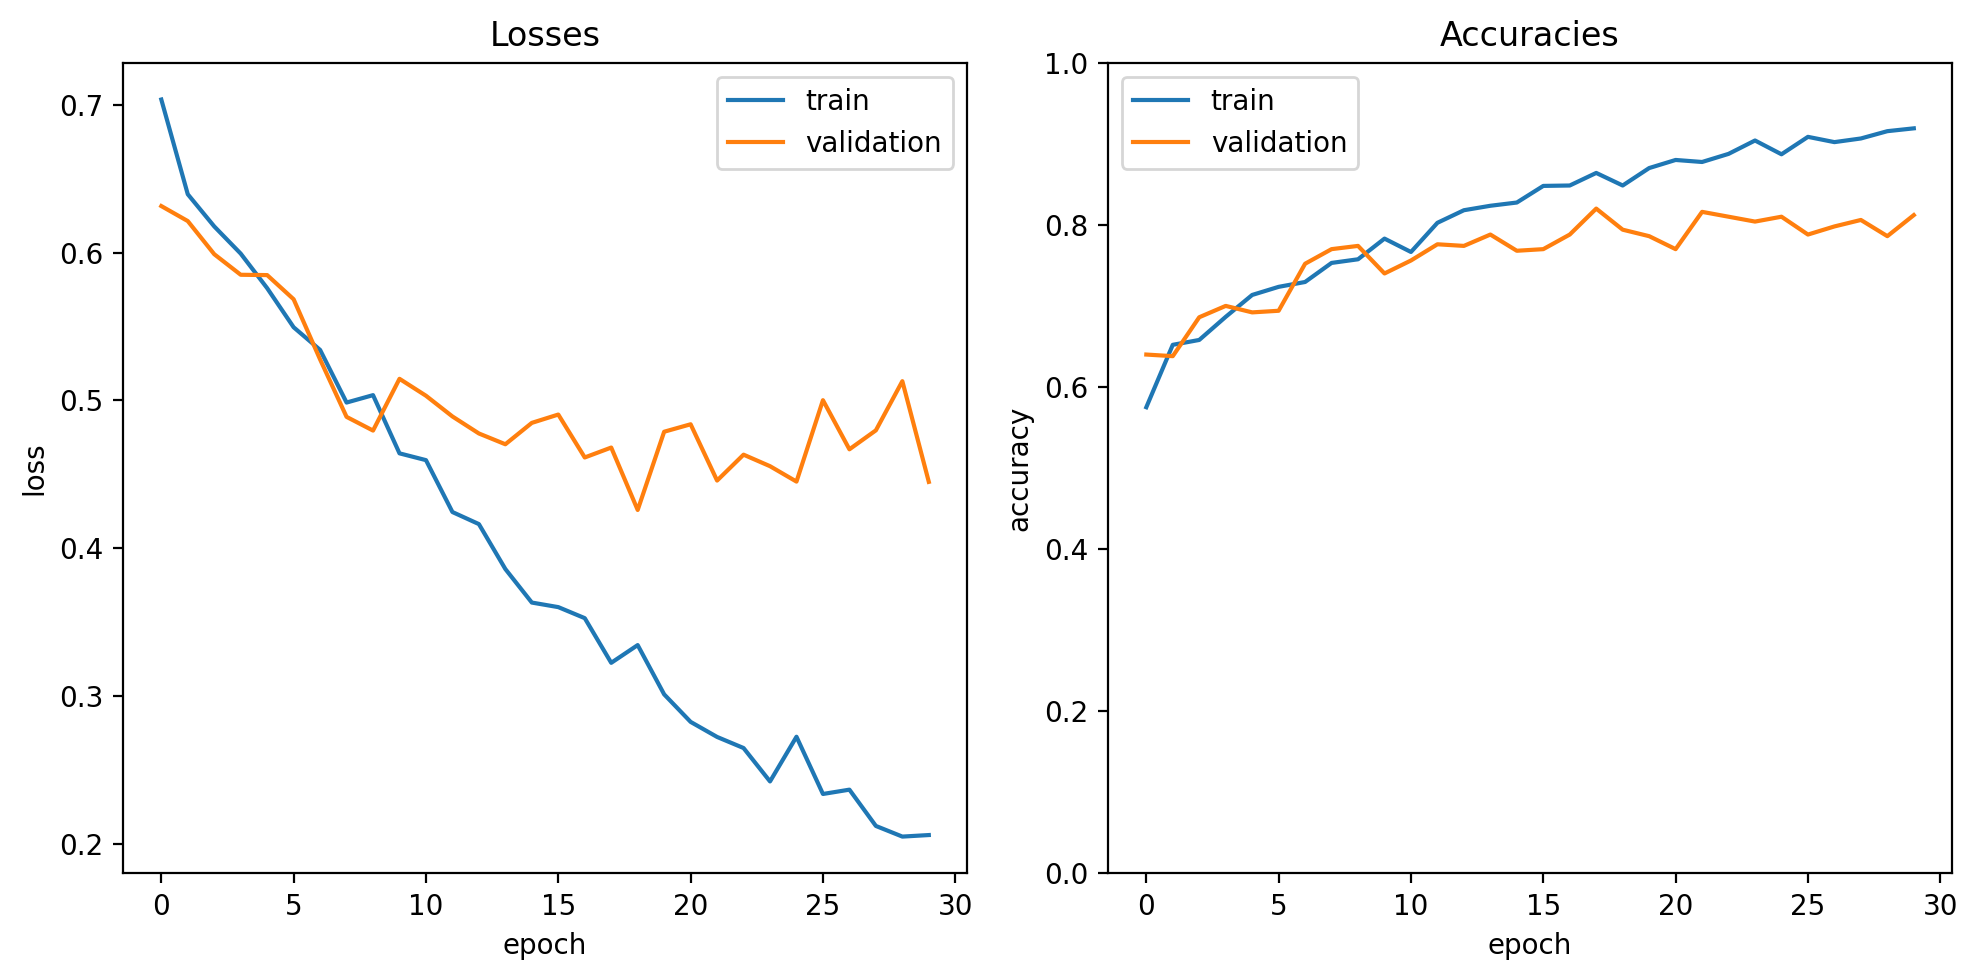

final train accuracy: 0.9190
final validation accuracy: 0.8120
final train loss: 0.2060
final validation loss: 0.4449


In [14]:
plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()
plt.show()

print(f"final train accuracy: {train_accuracies[-1]:.4f}")
print(f"final validation accuracy: {validation_accuracies[-1]:.4f}")
print(f"final train loss: {train_losses[-1]:.4f}")
print(f"final validation loss: {validation_losses[-1]:.4f}")


### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

In [15]:
# TODO
# 1. Calculate and show the test_dataset accuracy of your model.
# 2. Visualize some correctly and incorrectly classified examples.

In [15]:
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=4
)
model.eval()
with torch.no_grad():
    correct_preds = torch.tensor([], device=device)
    num_correct = 0
    for batch in test_dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        y_hat = model(inputs)
        y_pred = torch.argmax(y_hat, axis=1)
        correct_preds_batch = torch.eq(y_pred, labels)
        num_correct += torch.sum(correct_preds_batch).item()
        correct_preds = torch.cat((correct_preds, correct_preds_batch))

    accuracy = num_correct / len(test_dataloader.dataset)

print(f"Test Accuracy = {accuracy:.4f}")

Test Accuracy = 0.7800


correctly classified examples


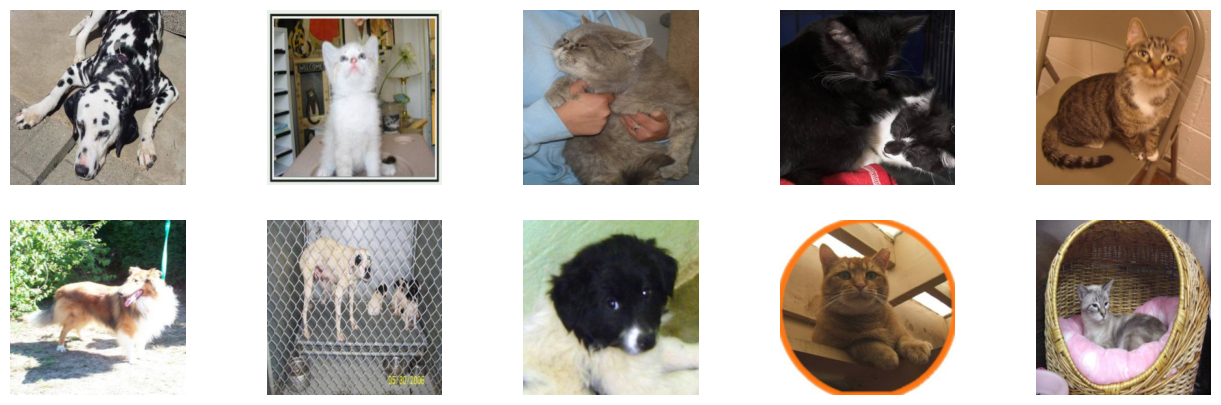


incorrectly classified examples


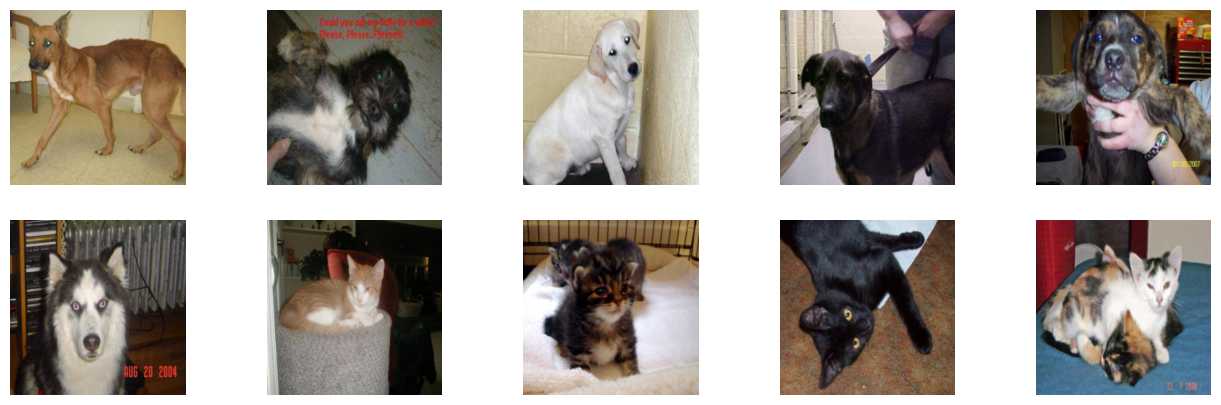

In [16]:
N = 10
plt.rcParams["figure.dpi"] = 100

print("correctly classified examples")
plt.figure(figsize=(16, 5))
for i in range(N):
    img_idx = correct_preds.nonzero()[i]
    plt.subplot(2, 5, i + 1)
    show_normalized_image(test_dataset[img_idx][0])
plt.show()

print()
print("incorrectly classified examples")
plt.figure(figsize=(16, 5))
for i in range(N):
    img_idx = (1 - correct_preds).nonzero()[i]
    plt.subplot(2, 5, i + 1)
    show_normalized_image(test_dataset[img_idx][0])
plt.show()

### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.

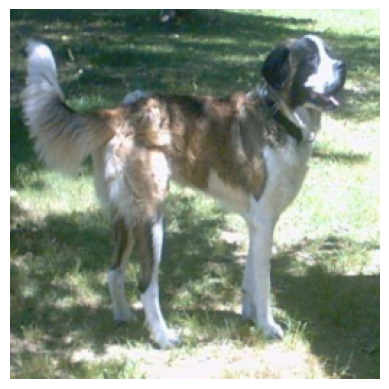

In [17]:
image = validation_dataset[10][0]
show_normalized_image(image)

Now, we are going to *clip* our model at different points to get different intermediate representation. 
* Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



In [18]:
# generate the intermediate output and print its shape
# TODO
img = torch.reshape(image.to(device), (1, *image.shape))

clipped1 = nn.Sequential(*(list(model.children())[:2]))
intermediate_output1 = clipped1(img)
print(f"clipped output 1 shape: {intermediate_output1.shape}")

clipped2 = nn.Sequential(*(list(model.children())[:8]))
intermediate_output2 = clipped2(img)
print(f"clipped output 2 shape: {intermediate_output2.shape}")

clipped3 = nn.Sequential(*(list(model.children())[:12]))
intermediate_output3 = clipped3(img)
print(f"clipped output 3 shape: {intermediate_output3.shape}")

clipped output 1 shape: torch.Size([1, 64, 128, 128])
clipped output 2 shape: torch.Size([1, 128, 32, 32])
clipped output 3 shape: torch.Size([1, 256, 16, 16])


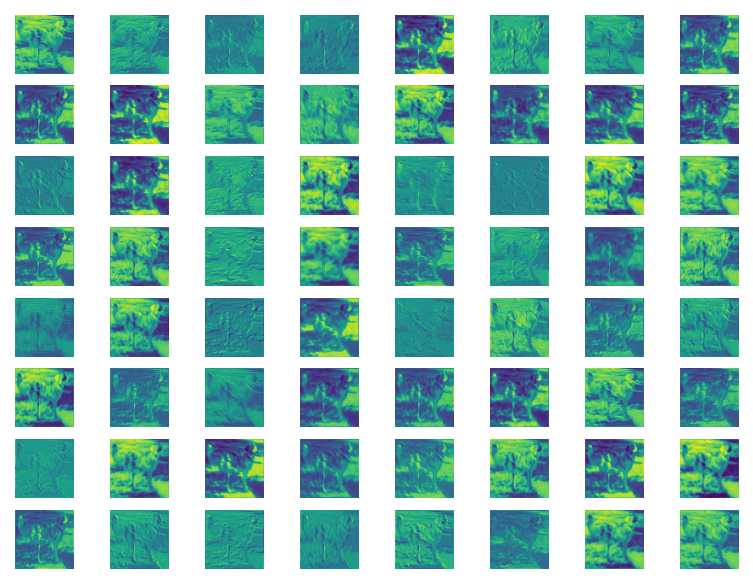

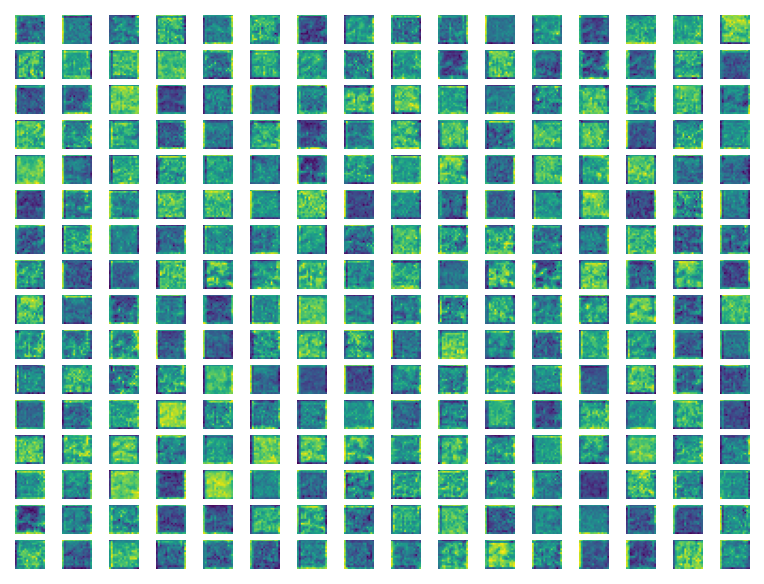

In [19]:
import math


def plot_intermediate_output(result, title=None):
    """Plots the intermediate output of shape
    N_FILTERS x H x W
    """
    plt.rcParams["figure.dpi"] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i * N + j < n_filters:
                axs[i][j].imshow(result[0, i * N + j].cpu().detach())
                axs[i][j].axis("off")


# TODO:
# pick a few intermediate representations from your
# network and plot them using the provided function.
plot_intermediate_output(intermediate_output1)
plot_intermediate_output(intermediate_output2)
plot_intermediate_output(intermediate_output3)

### Question
What can you say about those filters? What features are they focusing on?

Filters of the first intermediate output are quite understandable.
 - some filters are trying to understand different edges (vertical, horizontal and the overal borders of the main object) and the basic structure of the main object
 - some filters are focusing on the colors and tones with different focuses on different parts of the image

As we dive deeper in the model, filter visualizations are less interpretable by eye because the model is trying to understand more complicated patterns and it also has smaller dimensions for its feature maps.